In [215]:
'''An implementation of the stochastic ensemble kalman filter without the explicit Kalman gain 
and the perturbed measurements coming from a poisson distribution. '''

import numpy as np 
import matplotlib.pyplot as plt

'''Tau leaping model so we have some stochasticity. '''

days = 150
delta_t = 0.1 
rng = np.random.default_rng(5)

def model(theta,rng,*,days,delta_t): 
    gamma,xi = theta

    log_beta_damping = 1/35
    log_beta_mean = np.log(0.15)
    log_beta_standard_deviation = 0.20

    A = np.exp(-log_beta_damping * delta_t)
    M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
    C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    SI = np.zeros(days * int(1/delta_t))
    IR = np.zeros(days * int(1/delta_t))
    RS = np.zeros(days * int(1/delta_t))

    log_beta = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 10000
    I[0] = 5
    R[0] = 0
    log_beta[0] = np.log(0.30)

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        log_beta_t = A * log_beta[t-1] - M + C * rng.normal()

        dN_SI = rng.poisson(max(np.exp(log_beta_t) * (S[t-1] * I[t-1]/N) * delta_t,0.))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0.))
        dN_IR = min(dN_IR,I[t-1])

        dN_RS = rng.poisson(max(R[t-1] * xi * delta_t,0.))
        dN_RS = min(dN_RS,R[t-1])

        SI[t] = dN_SI
        IR[t] = dN_IR
        RS[t] = dN_RS

        S[t] = S[t-1] - dN_SI + dN_RS
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR - dN_RS
        log_beta[t] = log_beta_t

    return (S,I,R,SI,IR,RS,log_beta) 

theta = (0.05,1/90) #Real parameters
S_model,I_model,R_model,SI_model,IR_model,RS_model,log_beta_model = model(theta,rng,days = days,delta_t = delta_t)

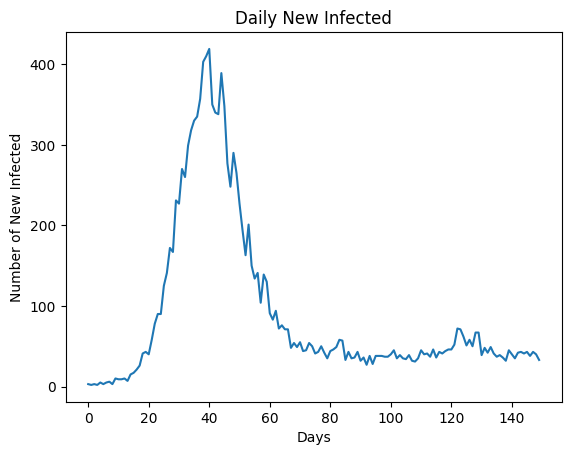

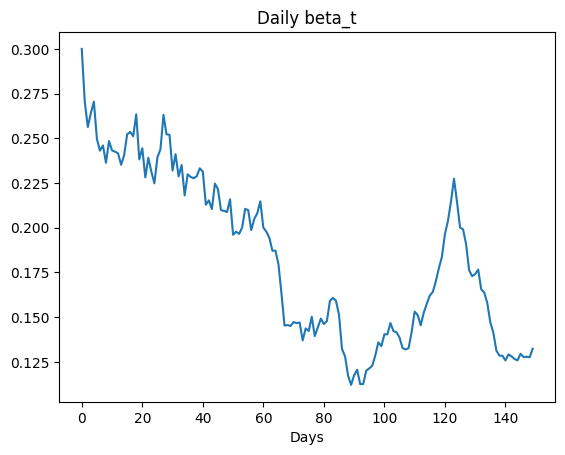

In [216]:
#Extract the data daily
data_real = SI_model.reshape((days,int(1/delta_t))).sum(axis = 1)
log_beta_real = log_beta_model[::int(1/delta_t)]

plt.title('Daily New Infected')
plt.xlabel('Days')
plt.ylabel('Number of New Infected')
plt.plot(np.arange(0,days,1),data_real)
plt.show()

plt.title('Daily beta_t')
plt.xlabel('Days')
plt.plot(np.arange(0,days,1),np.exp(log_beta_real))
plt.show()

In [217]:
def single_step(theta,state,rng,*,delta_t,log = False): 
    gamma,xi = theta
    if log: 
        gamma = np.exp(gamma)
        xi = np.exp(xi)

    S0,I0,R0,_,_,_,log_beta0 = state

    log_beta_damping = 1/35
    log_beta_mean = np.log(0.15)
    log_beta_standard_deviation = 0.20

    A = np.exp(-log_beta_damping * delta_t)
    M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
    C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

    S = np.zeros(int(1/delta_t))
    I = np.zeros(int(1/delta_t))
    R = np.zeros(int(1/delta_t))

    SI = np.zeros(int(1/delta_t))
    IR = np.zeros(int(1/delta_t))
    RS = np.zeros(int(1/delta_t))

    log_beta = np.zeros(int(1/delta_t))

    S[0] = S0
    I[0] = I0
    R[0] = R0
    log_beta[0] = log_beta0

    N = S0 + I0 + R0

    for t in range(1,int(1/delta_t)): 

        #Rate equations
        log_beta_t = A * log_beta[t-1] - M + C * rng.normal()
        dN_SI = rng.poisson(max(np.exp(log_beta_t) * (S[t-1] * I[t-1]/N) * delta_t,0.))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0.))
        dN_IR = min(dN_IR,I[t-1])

        dN_RS = rng.poisson(max(R[t-1] * xi * delta_t,0.))
        dN_RS = min(dN_RS,R[t-1])

        SI[t] = dN_SI
        IR[t] = dN_IR
        RS[t] = dN_RS

        S[t] = S[t-1] - dN_SI + dN_RS
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR - dN_RS
        log_beta[t] = log_beta_t

    return np.array([S[-1],I[-1],R[-1],SI.sum(),IR.sum(),RS.sum(),log_beta[-1]]).squeeze()

In [218]:
H = np.array([0.,0.,0.,1.,0.,0.]) #Observation operator
num_ensemble_members = 1000
members = np.full((num_ensemble_members,7),np.array([10000,5,0,0,0,0,np.log(0.30)])) #Initialize the particles with the correct I.C.

ensemble_mean = np.zeros((len(data_real),7))
ensemble_cov = np.zeros((len(data_real),7,7))

for index,observation in enumerate(data_real): 
    observation = np.array([observation])

    if index > 0: 
        for member_index in range(num_ensemble_members): 
            members[member_index,...] = single_step(theta,members[member_index,...],rng,delta_t = 0.1)

    #Analysis
    mean = np.mean(members,axis = 0)
    state_perturbation_matrix = 1/np.sqrt(num_ensemble_members - 1) * (members - mean)

    obs_mean = mean[3]
    obs_perturbation_matrix = 1/np.sqrt(num_ensemble_members - 1) * (members[:,3] - obs_mean)

    cross_cov = state_perturbation_matrix.T @ obs_perturbation_matrix.T
    cross_cov = cross_cov[:,np.newaxis]

    S = obs_perturbation_matrix[:,np.newaxis].T @ obs_perturbation_matrix[:,np.newaxis]

    perturbed_observations = np.full((num_ensemble_members,len(observation)),observation)
    perturbed_observations = rng.poisson(perturbed_observations)


    S_inv = np.linalg.pinv(S)
    for member_index in range(num_ensemble_members): 
        innovation = perturbed_observations[member_index] - members[member_index,3]
        alpha = S_inv @ innovation

        members[member_index,...] = members[member_index,...] + cross_cov @ alpha

    #Statistics
    ensemble_mean[index,...] = np.mean(members,axis = 0)
    ensemble_cov[index,...] = np.cov(members.T)

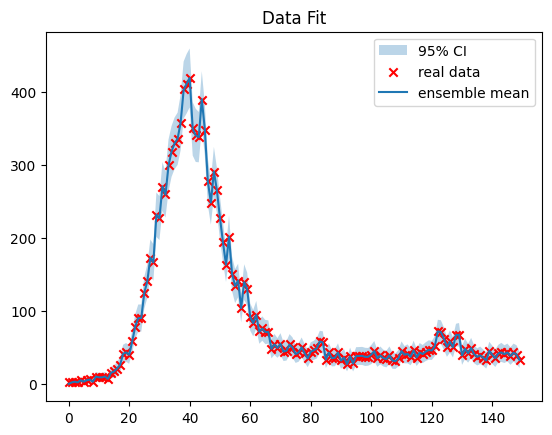

In [219]:
std_SI = np.sqrt(ensemble_cov[:,3,3])

lower = ensemble_mean[:,3] - 1.96 * std_SI
upper = ensemble_mean[:,3] + 1.96 * std_SI

plt.title('Data Fit')
plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3,label = '95% CI')
plt.scatter(np.arange(0,days,1),data_real,marker = 'x', color = 'red',label = 'real data')
plt.plot(np.arange(0,days,1),ensemble_mean[:,3],label = 'ensemble mean')
plt.legend()

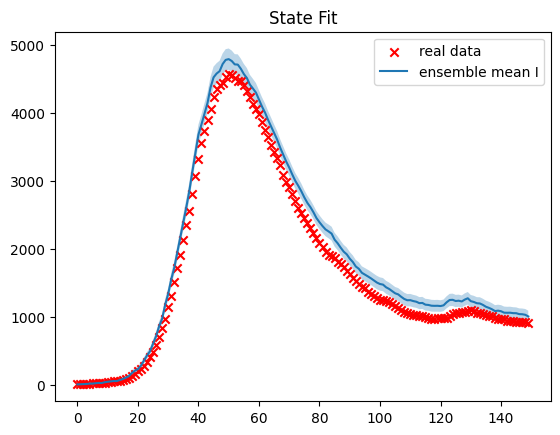

In [220]:
std_I = np.sqrt(ensemble_cov[:,1,1])

lower = ensemble_mean[:,1] - 1.96 * std_I
upper = ensemble_mean[:,1] + 1.96 * std_I

plt.title('State Fit')
plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3)
plt.scatter(np.arange(0,days,1),I_model[::int(1/delta_t)],marker = 'x', color = 'red',label = 'real data')
plt.plot(np.arange(0,days,1),ensemble_mean[:,1],label = 'ensemble mean I')
plt.legend()

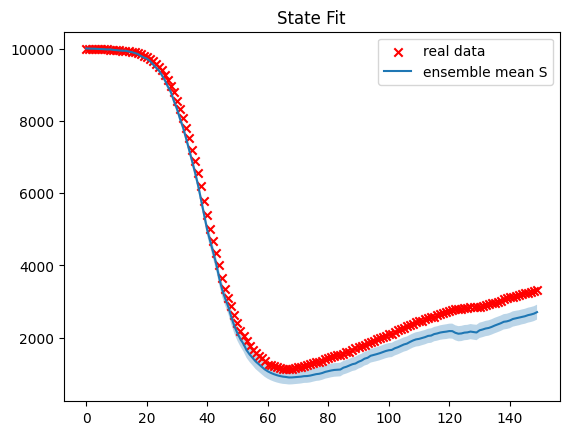

In [221]:
std_S = np.sqrt(ensemble_cov[:,0,0])

lower = ensemble_mean[:,0] - 1.96 * std_S
upper = ensemble_mean[:,0] + 1.96 * std_S

plt.title('State Fit')
plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3)

plt.scatter(np.arange(0,days,1),S_model[::int(1/delta_t)],marker = 'x', color = 'red',label = 'real data')
plt.plot(np.arange(0,days,1),ensemble_mean[:,0],label = 'ensemble mean S')
plt.legend()

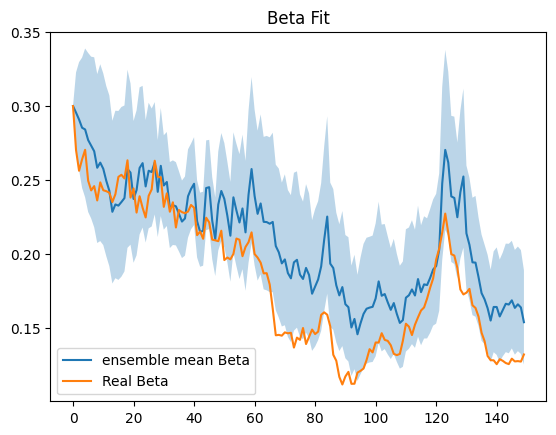

In [222]:
plt.title('Beta Fit')

std_beta = np.sqrt(ensemble_cov[:,-1,-1])

lower = np.exp(ensemble_mean[:,-1] - 1.96 * std_beta)
upper = np.exp(ensemble_mean[:,-1] + 1.96 * std_beta)

plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3)
plt.plot(np.arange(0,days,1),np.exp(ensemble_mean[:,-1]),label = 'ensemble mean Beta')
plt.plot(np.arange(0,days,1),np.exp(log_beta_real),label = 'Real Beta')
plt.legend()